# 1. Setup

In [1]:
import sklearn
import datetime
import os,pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt 
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 2. Load Data

In [2]:
df = pd.read_csv(r'C:\Users\USER\Downloads\AI_SHRDC\Capstone3\ecommerceDataset.csv')

# 3. Data Inspection

In [3]:
df.keys()

Index(['Household', 'Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and s

In [4]:
# Change the columns name
df.columns = ['items','comments']

In [5]:
df.keys()

Index(['items', 'comments'], dtype='object')

In [6]:
print("Shape of the data:\n ", df.shape)

Shape of the data:
  (50424, 2)


In [7]:
print('Data info:\n ', df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50424 entries, 0 to 50423
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   items     50424 non-null  object
 1   comments  50423 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB
Data info:
  None


In [8]:
print('Data description:\n' ,df.describe().transpose())

Data description:
           count unique                                                top  \
items     50424      4                                          Household   
comments  50423  27801  Think & Grow Rich About the Author NAPOLEON HI...   

           freq  
items     19312  
comments     30  


In [9]:
print('Example data:\n', df.head(1))

Example data:
        items                                           comments
0  Household  SAF 'Floral' Framed Painting (Wood, 30 inch x ...


In [10]:
# Count each category
categories_list = df['items'].unique()
print(df['items'].value_counts())

items
Household                 19312
Books                     11820
Electronics               10621
Clothing & Accessories     8671
Name: count, dtype: int64


# 4. Data Cleaning

In [11]:
# See null value
print(df.isna().sum())

items       0
comments    1
dtype: int64


In [12]:
# Drop null value
df = df.dropna()
print(df['items'].value_counts())

items
Household                 19312
Books                     11820
Electronics               10621
Clothing & Accessories     8670
Name: count, dtype: int64


# 5. Data Preprocessing

In [13]:
# seperate feature and targets(labels)
features = df['comments'].values
labels = df['items'].values

In [14]:
# Convert categorical data into interger
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
print(len(labels_encoded))

50423


In [15]:
# Split train and test datasets
X_train,X_test,y_train,y_test = train_test_split(features, labels_encoded, train_size=0.9, random_state=42)

# 6. Setuping Tokenizers

In [16]:
# Define Hyperparameters
vocab_size = 5000
oov_token = '<OOV>'
max_length = 200
embedding_dim = 64

In [17]:
# Define Tokenizer
tokenizer = keras.preprocessing.text.Tokenizer(
    num_words=vocab_size,
    split=" ",
    oov_token=oov_token
)
tokenizer.fit_on_texts(X_train)

In [18]:
word_index = tokenizer.word_index
print(dict(list(word_index.items())[0:10]))

{'<OOV>': 1, 'the': 2, 'and': 3, 'of': 4, 'to': 5, 'a': 6, 'for': 7, 'in': 8, 'with': 9, 'is': 10}


In [19]:
# Tokenizing Train and Test dataset
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

In [20]:
X_train_padded = keras.utils.pad_sequences(
    X_train_tokens,
    maxlen=max_length,
    padding="post",
    truncating="post" # cut from behind
)

X_test_padded = keras.utils.pad_sequences(
    X_test_tokens,
    maxlen=max_length,
    padding="post",
    truncating="post" # cut from behind
)

# 7. Model Development

In [57]:
# Layers and Activation input
mutli_catergorical = keras.Sequential()
mutli_catergorical.add(keras.layers.Embedding(vocab_size, embedding_dim))
mutli_catergorical.add(keras.layers.Bidirectional(keras.layers.LSTM(12)))
mutli_catergorical.add(keras.layers.Dense(12,activation='relu'))
mutli_catergorical.add(keras.layers.Dense(len(np.unique(labels)), activation='softmax'))

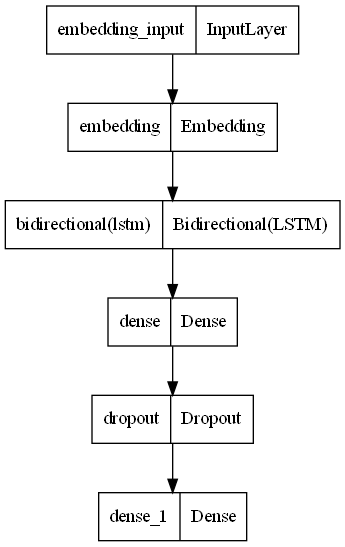

In [22]:
keras.utils.plot_model(mutli_catergorical)

In [23]:
mutli_catergorical.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, 96)               43392     
 l)                                                              
                                                                 
 dense (Dense)               (None, 48)                4656      
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 196       
                                                                 
Total params: 368,244
Trainable params: 368,244
Non-trainable params: 0
__________________________________________________

In [58]:
# Compiling model
mutli_catergorical.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])

In [44]:
PATH = os.getcwd()
logpath = os.path.join(PATH,'tensorboard_log',datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tb = keras.callbacks.TensorBoard(logpath)

In [45]:
checkpoint_filepath = 'checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,save_best_only=True,monitor='val_loss', mode='auto', verbose=1)

In [46]:
early_stopping = keras.callbacks.EarlyStopping(patience=2,monitor='val_loss',restore_best_weights=True)

In [59]:
max_epoch = 5
history = mutli_catergorical.fit(
    X_train_padded,y_train,
    validation_data=(X_test_padded,y_test),
    epochs =max_epoch,
    callbacks=[early_stopping,tb,model_checkpoint_callback]
    )

Epoch 1/5
1419/1419 [==============================] - ETA: 0s - loss: 0.2762 - accuracy: 0.9119
Epoch 1: val_loss did not improve from 0.09312
1419/1419 [==============================] - 50s 33ms/step - loss: 0.2762 - accuracy: 0.9119 - val_loss: 0.1160 - val_accuracy: 0.9687
Epoch 2/5
1419/1419 [==============================] - ETA: 0s - loss: 0.0875 - accuracy: 0.9771
Epoch 2: val_loss did not improve from 0.09312
1419/1419 [==============================] - 46s 32ms/step - loss: 0.0875 - accuracy: 0.9771 - val_loss: 0.0962 - val_accuracy: 0.9754
Epoch 3/5
1418/1419 [============================>.] - ETA: 0s - loss: 0.0577 - accuracy: 0.9841
Epoch 3: val_loss improved from 0.09312 to 0.09201, saving model to checkpoint.h5
1419/1419 [==============================] - 45s 32ms/step - loss: 0.0578 - accuracy: 0.9841 - val_loss: 0.0920 - val_accuracy: 0.9772
Epoch 4/5
1419/1419 [==============================] - ETA: 0s - loss: 0.0423 - accuracy: 0.9888
Epoch 4: val_loss improved from

In [37]:
mutli_catergorical.load_weights(checkpoint_filepath)

In [38]:
from sklearn.metrics import classification_report

y_pred = mutli_catergorical.predict(X_test_padded)
y_pred_index = np.argmax(y_pred, axis=1)

# Print classification report
report = classification_report(y_test, y_pred_index)
print("Classification Report:")
print(report)


158/158 [==============================] - 2s 13ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1208
           1       0.99      0.98      0.99       865
           2       0.96      0.98      0.97      1042
           3       0.97      0.98      0.98      1928

    accuracy                           0.98      5043
   macro avg       0.98      0.98      0.98      5043
weighted avg       0.98      0.98      0.98      5043



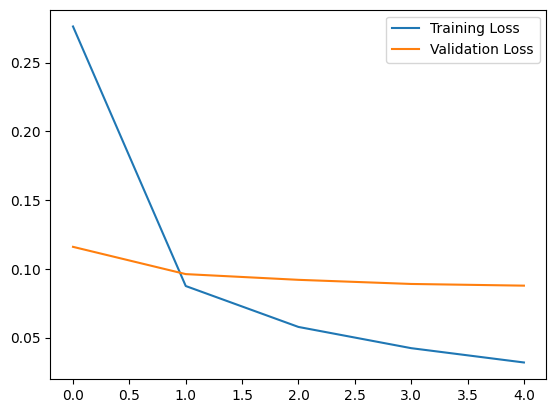

In [60]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss','Validation Loss'])
plt.show()

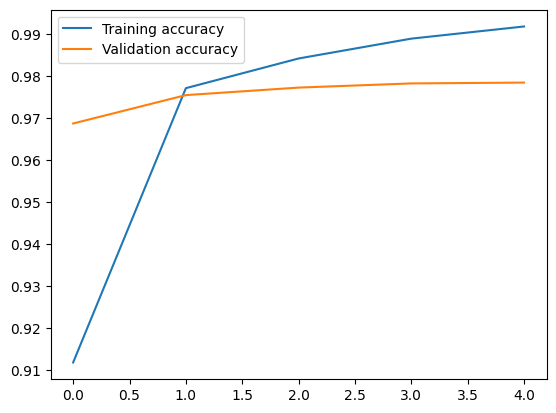

In [61]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show()

# 8. Save Model

In [33]:
PATH = os.getcwd()
print(PATH)

c:\Users\USER\Downloads\AI_SHRDC\Capstone3


In [34]:
tokenizer_save_path = os.path.join(PATH,'tokenizer_mutliclass.json')
with open(tokenizer_save_path,'wb') as f:
    pickle.dump(tokenizer,f)

In [35]:
label_enconder_save_path = os.path.join(PATH,'label_encoder_mutliclass.pkl')
with open(label_enconder_save_path,'wb') as f:
    pickle.dump(label_encoder,f)

In [36]:
mutli_catergorical.save(r'CP\run.h5')